# GEN ALL

*This notebook is intended to be used as a generator of adversarial examples using all five methods.*

## Structure

- Imports
- Global settings
  - Max norm, size of max-norm ball in which I seek for adversarial examples
    - 50 / 255
  - Model that is used
    - MnistCnnPatt
  - batch_size - number of benign examples
    - 10 for testing, 1000 for real application
- Functions that create adversarial examples given benign examples
  - In batch mode
- Generation mechanism and statistics capture
  - save generated adv. examples as images
  - percentage of success of attack

## Requirements

- Simple parallelization
  - meaning that computation can be split across several jupyter notebooks eventually

# 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

In [3]:
import torch.nn as nn
import torch

In [4]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [5]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Gloabal settings

In [6]:
max_norm = 50 / 255

In [8]:
model = ModelManager.get_trained(ModelType.MnistCnnB)

In [9]:
batch_size = 10

In [10]:
data = MnistData(True)

# 2. Functions for adv. examples

### 1. FGSM

In [19]:
def fgsm(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    benign_examples = benign_examples.detach()
    benign_examples.requires_grad = True
    if benign_examples.grad is not None:
        benign_examples.grad.zero_()
    loss = loss_fn(model(benign_examples), labels)
    loss.backward()
    adversarial_examples = benign_examples + max_norm * benign_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)
    return Clipper.clip_for_image(adversarial_examples)

### 2. I-FGSM

In [20]:
def ifgsm(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach()
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = Clipper.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 3. PGD

In [21]:
def pgd(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach() + 2 * max_norm * (torch.rand((len(labels), 1, 28, 28)) - 0.5)
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = Clipper.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 4. L-BFGS

In [14]:
def solve_for_targeted(model, benign_example, target_label, c_lambda, label, max_norm) -> torch.Tensor:
    print(f'\t{target_label}, {c_lambda}')
    step_size = 1e-2
    benign_example = benign_example.unsqueeze(0)
    while len(benign_example.shape) > 4:
        benign_example = benign_example.squeeze(0)
    adv = torch.zeros(benign_example.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = c_lambda * norm_of_diff(adv, benign_example) \
            + loss_fn(model(adv), torch.Tensor([target_label]).type(torch.long))
        loss.backward()
        new_adv = Clipper.clip(
            benign_example,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            max_norm
        )
        adv = new_adv
    if torch.argmax(model(adv), dim=1)[0] == target_label or c_lambda < 1e-5:
        return adv.squeeze(0)
    return None

def lbfgs(model: nn.Module, benign_examples:torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    adversarial_examples = []
    for i in range(len(benign_examples)):
        benign_example, label = benign_examples[i], labels[i]
        advs = []
        for i in [j for j in range(10) if j != label]:
            c_lambda = 1
            adv = None
            while adv is None:
                adv = solve_for_targeted(model, benign_example, i, c_lambda, label, max_norm)
                c_lambda *= 0.7
            advs.append(adv)

        norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
        norms = []
        for adve in advs:
            norms.append(norm_of_diff(benign_example, adve))
        else:
            minout = min(norms)
            for i in range(len(advs)):
                if norms[i] == minout:
                    adversarial_examples.append(advs[i])
                    break
    return torch.Tensor([example.tolist() for example in adversarial_examples])

### 5. CW

In [15]:
def solve_for(model, benign_image, label, c_lambda, max_norm):
    step_size = 1e-2
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
    adv = adv.unsqueeze(0)
    benign_image = benign_image.unsqueeze(0)
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = norm_of_diff(adv, benign_image) \
            - c_lambda * loss_fn(model(adv), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = Clipper.clip(
            benign_image,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            max_norm
        )
        adv = new_adv
    if torch.argmax(model(adv), dim=1)[0] != label or c_lambda > 10:
        return adv.squeeze(0)
    return None

def cw(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    advs = []
    for i in range(len(benign_examples)):
        print(f'--- {i} ---')
        benign_example, label = benign_examples[i], labels[i]
        adv = None
        c_lambda = 1e-2
        while adv is None:
            adv = solve_for(model, benign_example, label, c_lambda, max_norm)
            c_lambda *= 1.1
        advs.append(adv)
    return torch.Tensor([adv.tolist() for adv in advs])

# 3. Generation mechanism

In [17]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [22]:

# Generation
fgsm_examples = fgsm(model, benign_examples, labels, max_norm)
ifgsm_examples = ifgsm(model, benign_examples, labels, max_norm)
pgd_examples = pgd(model, benign_examples, labels, max_norm)
lbfgs_examples = lbfgs(model, benign_examples, labels, max_norm)
cw_examples = cw(model, benign_examples, labels, max_norm)

	0, 1
	0, 0.7
	0, 0.48999999999999994
	0, 0.3429999999999999
	0, 0.24009999999999992
	0, 0.16806999999999994
	0, 0.11764899999999995
	0, 0.08235429999999996
	0, 0.05764800999999997
	0, 0.04035360699999998
	0, 0.028247524899999984
	0, 0.019773267429999988
	0, 0.01384128720099999
	0, 0.009688901040699992
	0, 0.006782230728489994
	0, 0.004747561509942996
	0, 0.003323293056960097
	0, 0.002326305139872068
	0, 0.0016284135979104473
	0, 0.001139889518537313
	0, 0.000797922662976119
	0, 0.0005585458640832833
	0, 0.00039098210485829826
	0, 0.0002736874734008088
	0, 0.00019158123138056615
	0, 0.00013410686196639628
	0, 9.387480337647739e-05
	0, 6.571236236353417e-05
	0, 4.5998653654473914e-05
	0, 3.219905755813174e-05
	0, 2.2539340290692216e-05
	0, 1.577753820348455e-05
	0, 1.1044276742439186e-05
	0, 7.73099371970743e-06
	1, 1
	1, 0.7
	1, 0.48999999999999994
	1, 0.3429999999999999
	1, 0.24009999999999992
	1, 0.16806999999999994
	1, 0.11764899999999995
	1, 0.08235429999999996
	1, 0.05764800999999

fgsm: 3
ifgsm: 8
pgd: 8
lbfgs: 3
cw: 8


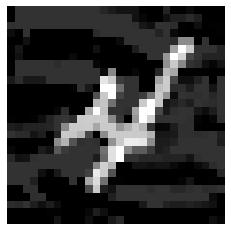

In [23]:

# Save'em all
for i in range(batch_size):
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\benign_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(fgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\fgsm_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(ifgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\ifgsm_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(pgd_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\pgd_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\lbfgs_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\cw_{i}.png", bbox_inches="tight", pad_inches=0)

fgsm_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, fgsm_examples)
print(f'fgsm: {len(fgsm_adversarials)}')

ifgsm_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, ifgsm_examples)
print(f'ifgsm: {len(ifgsm_adversarials)}')

pgd_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, pgd_examples)
print(f'pgd: {len(pgd_adversarials)}')

lbfgs_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_examples)
print(f'lbfgs: {len(lbfgs_adversarials)}')

cw_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_examples)
print(f'cw: {len(cw_adversarials)}')    

# 4. Ad Hoc